In [211]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")  # 定义文本框与箭头的格式
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")



In [212]:
##信息熵
def Entropy(data):
    labellist = {} #记录yes和no的个数
    for tmp in data:
        if tmp[-1] not in labellist:
            labellist[tmp[-1]] = 1
        else:
            labellist[tmp[-1]]+=1
    
    dataEntropy = 0
    for tmp in labellist:
        dataEntropy-=(labellist[tmp]/len(data)) * math.log2(labellist[tmp]/len(data))
    return dataEntropy


In [213]:

def spliteData(data,value,i):
    newdata=[]
    for row in data:
        if row[i]==value:
            newVec = row[:i]
            newVec.extend(row[i + 1:])
            newdata.append(newVec)
    return newdata


In [214]:
def condEntropy(data,i):
    #获取data第i列的各个值 如i=0时，allValue=[1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
    allValue = [example[i] for example in data]
    #获取allValue中不同的类别，set具有去重的作用 ，如i=1时，上面的allValue现在等于{0, 1}

    allValue=set(allValue)
    conditionEntropy=0
    for key in allValue:
        newdata=spliteData(data,key,i)
        conditionEntropy=conditionEntropy+len(newdata)/len(data) *Entropy(newdata)
    return conditionEntropy



In [215]:
#选择最优划分
def optimalPartition(data, attribute):
    originalEntroy=Entropy(data)
    bestGainEnt=0
    bestopt=-1
    attributeLen=len(attribute)
    for i in range(attributeLen):
        #获取data第i列的各个值 如i=0时，allValue=[1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
        #allValue = [example[i] for example in data]
        #获取allValue中不同的类别，set具有去重的作用 ，如i=1时，上面的allValue现在等于{0, 1}
        #allValue=set(allValue)
        conditionEntropy = condEntropy(data, i)
        #conditionEntropy=0
        #for value in allValue:
            #newdata=spliteData(data,value,i)
            #conditionEntropy=conditionEntropy+len(newdata)/len(data) *Entropy(newdata)
        gainEntropy = originalEntroy-conditionEntropy
        if gainEntropy > bestGainEnt:
            bestGainEnt = gainEntropy
            bestopt = i
    return bestopt




In [216]:
##计算哪个类别最多
def majorityCnt(datalabel):
    labelCnt = {}
    for key in datalabel:
        if key not in labelCnt:
            labelCnt[key] = 1
        else :
            labelCnt[key] +=1
    
    labelCnt = sorted(labelCnt.items(), key= lambda x :x[1], reverse=True)
    return labelCnt[0][0]

In [217]:
#构建决策树
def createTree(data, attribute):
    attribute_copy = attribute[:]
    #获取yes和no的标签
    labels = [tmp[-1] for tmp in data]
    #全为一类
    if labels.count(labels[0]) == len(labels):
        return labels[0]
    #只剩一个属性
    if len(data[0]) == 1:
        return majorityCnt(labels)
    #其他情况
    bestopt = optimalPartition(data, attribute)
    bestattribute = attribute[bestopt]
    myTree={bestattribute:{}}
    allvalues = [tmp[bestopt] for tmp in data]
    allvalues = set(allvalues)

    del(attribute_copy[bestopt])
    for value in allvalues:
        #modify1
        myTree[bestattribute][value]=createTree(spliteData(data,value,bestopt),attribute_copy)
    #print(myTree)
    return myTree

    

In [218]:
#测试算法
def classify(decisionTree, testVec, attr_list):
    feature = list(decisionTree.keys())[0]          # feature为决策树的根节点
    feature_dict = decisionTree[feature]            # feature_dict为根节点下的子树
    feature_index = attr_list.index(feature)        # feature_index为feature对应的属性名索引
    feature_value = testVec[feature_index]          # feature_value为测试集中对应属性的值
    label = None
    if feature_value in feature_dict.keys():
        # 如果没有结果就继续向下找
        if type(feature_dict[feature_value]) == dict:
            label = classify(feature_dict[feature_value], testVec, attr_list)
        else:
            label = feature_dict[feature_value]
    return label

def testAccuracy(decisionTree, test_sample_list, test_label_list, attr_list):
    rightNum = 0
    predict_label_list = []
    for i in range(len(test_sample_list)):
        predict_label = classify(decisionTree, test_sample_list[i], attr_list)
        predict_label_list.append(predict_label)
        if predict_label == test_label_list[i][0]:
                rightNum += 1
    accuracy = rightNum/len(test_sample_list)
    return accuracy*100


In [219]:
#画图
def getNumLeafs(myTree):  # 获取树叶节点的数目
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':  # 测试节点的数据类型是不是字典，如果是则就需要递归的调用getNumLeafs()函数
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs


def getTreeDepth(myTree):  # 获取树的深度
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[
                    key]).__name__ == 'dict':  # test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth


# 绘制带箭头的注释
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)


# 计算父节点和子节点的中间位置，在父节点间填充文本的信息
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)


# 画决策树的准备方法
def plotTree(myTree, parentPt, nodeTxt):  # if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  # 计算树的宽度
    depth = getTreeDepth(myTree)  # 计算树的深度
    firstStr = list(myTree.keys())[0]  # the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[
                    key]).__name__ == 'dict':  # test to see if the nodes are dictonaires, if not they are leaf nodes
            plotTree(secondDict[key], cntrPt, str(key))  # recursion
        else:  # it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD


def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)  # no ticks
    # createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()


 Mytree:
{'inv-nodes': {'0-2': {'tumor-size': {'35-39': {'node-caps': {'yes': 'yes', 'no': 'no'}}, '30-34': {'deg-malig': {1: 'no', 2: {'breast-quad': {'right_low': 'no', 'left_low': 'yes', 'right_up': 'yes', 'left_up': {'age': {'60-69': 'no', '40-49': 'yes'}}}}, 3: {'breast-quad': {'right_up': 'no', 'left_up': {'Class': {'no-recurrence-events': 'no', 'recurrence-events': 'yes'}}, '?': 'no', 'left_low': 'no', 'central': 'no'}}}}, '50-54': {'breast': {'right': 'yes', 'left': 'no'}}, '0-4': 'no', '10-14': {'deg-malig': {1: 'no', 2: {'age': {'60-69': {'breast': {'right': 'yes', 'left': 'no'}}, '70-79': 'no', '30-39': 'no', '50-59': 'no', '40-49': {'breast': {'right': 'no', 'left': 'yes'}}}}}}, '25-29': {'age': {'60-69': {'Class': {'no-recurrence-events': 'no', 'recurrence-events': 'yes'}}, '50-59': 'no', '40-49': {'breast-quad': {'right_up': 'no', 'left_up': {'deg-malig': {2: {'breast': {'right': 'no', 'left': 'yes'}}, 3: 'yes'}}, 'left_low': {'deg-malig': {1: 'yes', 2: 'no'}}, 'central':

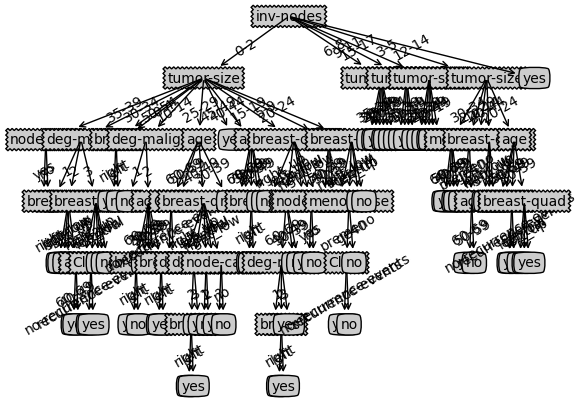

Accuracy : 74.0 %


In [220]:
##数据处理

data = pd.read_csv("./breast_cancer.csv", sep=',')
data = np.array(data)
#print(data)
train_data_x = data[50:250,:10]
#print(train_data_x.shape)
train_data_y = data[50:250,-1]
test_data_x = data[0:50,:9]
test_data_y = data[0:50,9:10]
attribute = ['Class', 'age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad']
test_data_x_list = train_data_x.tolist()

Tree = createTree(test_data_x_list, attribute)
print(" Mytree:")
print(Tree)
#createPlot(Tree)
test_data_x_list = test_data_x.tolist()
#print(test_data_x_list)
test_data_y_list = test_data_y.tolist()
#print(test_data_y_list)
print("Accuracy :", testAccuracy(Tree, test_data_x_list, test_data_y_list, attribute), "%")